<a href="https://colab.research.google.com/github/raphaelfontenelle/GAN/blob/main/GANProducingDigitsUsingGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Generative Adversarial Network

In [77]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
cuda = torch.cuda.is_available()
print(cuda)

True


In [78]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  image_unflat = image_tensor.detach().cuda().to(device='cpu').view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

# MNIST Dataset

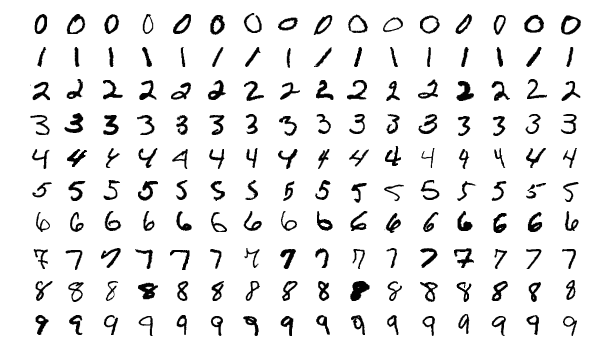

# Generator

In [79]:
def get_generator_block(input_dim, output_dim):
   return nn.Sequential(   
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [80]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
  def forward(self, noise):
       return self.gen(noise)

In [81]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

# Discriminator

In [82]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [83]:
class Discriminator(nn.Module):
     def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

     def forward(self, image):
        return self.disc(image)

In [84]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)
device = 'cuda'

In [85]:
gen = Generator(z_dim)
gen.to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator()
disc.to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [86]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    f_noise = get_noise(num_images, z_dim).to(device)
    f_gen = gen(f_noise)
    f_pred = disc(f_gen.detach())
    f_loss = criterion(f_pred, torch.zeros_like(f_pred))
    r_pred = disc(real)
    r_loss = criterion(r_pred, torch.ones_like(r_pred))
    disc_loss = (f_loss + r_loss) / 2
    return disc_loss

In [87]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    f_noise = get_noise(num_images, z_dim, device=device)
    f = gen(f_noise)
    f_pred = disc(f)
    gen_loss = criterion(f_pred, torch.ones_like(f_pred))
    return gen_loss

Epoch 1, step 500: Generator loss: 1.387227331399917, discriminator loss: 0.4193933829665186


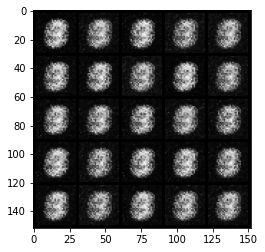

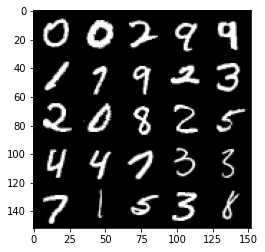

Epoch 2, step 1000: Generator loss: 1.6749122815132143, discriminator loss: 0.2993914920687678


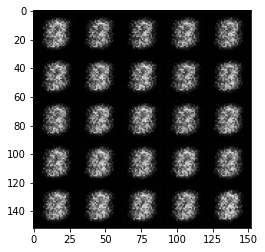

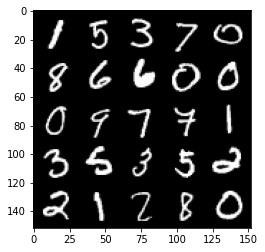

Epoch 3, step 1500: Generator loss: 1.9579824106693253, discriminator loss: 0.17460548242926613


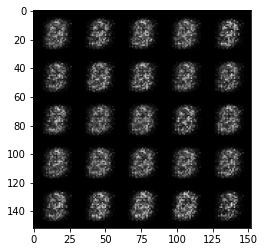

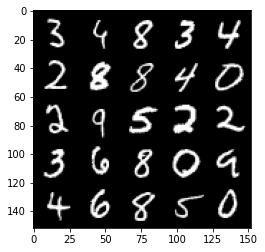

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device).to(device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1